# Modelling and Analysis - SuicideWatch

- Import and process data
- Transform to sparse matrix 
- TfidfV and downsampling 
- Import pre trained and optimised model 
- Analyse confusion matrix, ROC curves 
- Binarize target metric and manipulate thresholds 
- Analysis of coefficients 

## Imports

In [48]:
import pandas as pd
import numpy as np

import re

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import joblib

from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, mean_squared_error



## SuicideWatch

- Having repeated my modelling accross all three forums (anxiety, MentalHealth and SuicideWatch (SW), the accuracy score was highest in the SW. Thus, in the instance where I had most clarity, I focused my modelling and analysis on the SuicideWatch forum. 

- In the merged dataframe, the accuracy score was 10 percent above baseline, but had the lowest predictive ability compared with when the dataframes were seperate.  This could be due to the subreddit communities having features that uniquely increase or decrease their comment scores.


In [14]:
sw = pd.read_csv('../Datasets_capstone/sw_final.csv', encoding='utf8', engine='python')
del sw['Unnamed: 0']

In [15]:
sw.drop_duplicates('comment_body', keep='first', inplace=True)

In [16]:
def process_data(cell):
    return re.sub(r'\d+', '', cell)

In [17]:
sw.comment_body = sw.comment_body.apply(lambda x: process_data(x))

## Optimised tfidf 

- After performing a grid search and PCA, the optimum parameters found in the TfidfV model were 1,3 ngrams using 5000 features.

In [18]:
def model(df, n_features, ngram, method):
    if method == 'countv': 
        cvec = CountVectorizer(stop_words='english', max_features=n_features, ngram_range=ngram)
        cvec.fit(df)
        words = cvec.get_feature_names()
        wordcountdf = pd.DataFrame(cvec.transform(df).toarray(), columns = cvec.get_feature_names(), index = df)
        print(wordcountdf.shape)
        return wordcountdf
    else:
        tvec = TfidfVectorizer(stop_words='english', max_features=n_features, ngram_range=ngram)
        tvec.fit(df)
        words2 = tvec.get_feature_names()
        worddf2 = pd.DataFrame(tvec.transform(df).toarray(), columns = tvec.get_feature_names(), index = df)
        print(worddf2.shape)
        return worddf2

In [19]:
sw_tf = model(sw.comment_body, 5000, (1,3), 'tf')

(16275, 5000)


Here I will visualise the sparsity of my matrix: (very very sparse)
- Thus transform it to speed up computations 
- I ran a number of different classification models, including random forests and bagging models and found logistic regression to perform best.

In [10]:
sparse_dataset = csr_matrix(sw_tf)

There are unequal class sizes when splitting the y variable into 4. I attempted different up and down sampling techniques, including SMOTE and random under sampling.
- I chose the random down sampling method as it was computationally the fastest and easy in implementation.
- Limitation: Possibly gets rid of important data (randomly downsamples to the smallest class)

In [51]:
def sampling(X,y):
    y_b = pd.qcut(y, 4, labels = [0,1,2,3])
    print(pd.qcut(y, 4).value_counts())
    Xs,ys = RandomUnderSampler(replacement=True).fit_resample(X, y_b)
    print(Xs.shape, ys.shape)
    scaler = StandardScaler()
    Xs = pd.DataFrame(scaler.fit_transform(Xs), columns = X.columns)
    ys = pd.DataFrame(ys, columns=['comment_score'])
    
    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=1, shuffle=True)
    return X_train, X_test, y_train, y_test

In [52]:
X_traint, X_testt, y_traint, y_testt = sampling(sw_tf, sw.comment_score)

(1.0, 3.0]        4576
(-84.001, 1.0]    4230
(10.0, 1125.0]    3791
(3.0, 10.0]       3678
Name: comment_score, dtype: int64
(14712, 5000) (14712,)


Reload optimised and pretrained model
- This originally achieved a K fold cross val score of 0.501% and a test score of 0.55%. 30 Percent above baseline.
- However, when comments posted within 1 hour prior to data collection were removed, this decreased accuracy to 0.51% and and 0.47% K fold CV score. 

In [54]:
lr= joblib.load("lr_increasegrams.sav")

The baseline is 0.25 - Thus, we want to aim to improve this.

In [14]:
y_testt['comment_score'].value_counts(normalize=True).max()

0.25552157662249403

Use K fold cross validation because it is a better estimation of out of sample performance

In [28]:
kf = KFold(random_state=1)
cv = cross_val_score(lr, X_traint, y_traint, cv=kf).mean()

In [18]:
print('Training score', round(lr.score(X_traint, y_traint),2))
print('Testing score', round(lr.score(X_testt, y_testt),2))
print('CV score', round(cv,2)

Training score 0.66
Testing score 0.51
CV score 0.47


In [19]:
training_predictions = lr.predict(X_traint)
testing_predictions = lr.predict(X_testt)

[[1816  380  406  324]
 [ 479 1656  446  362]
 [ 212  157 2424  169]
 [ 333  399  377 1829]]


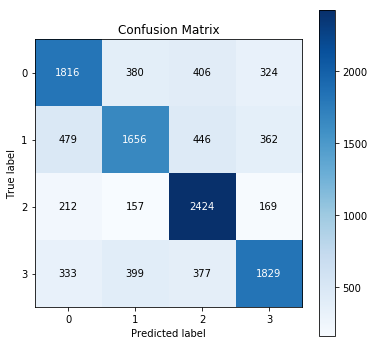

In [20]:
print(confusion_matrix(y_traint, training_predictions))

skplt.metrics.plot_confusion_matrix(y_traint, training_predictions, figsize=(6,6))
plt.show()

For the training matrix below, the model performs best in classifying the lowest and highest scoring comments, and less well on the middle two classes, especially the third. 

[[458 101 109  84]
 [118 407 113  97]
 [175 183 185 173]
 [ 90  98  91 461]]


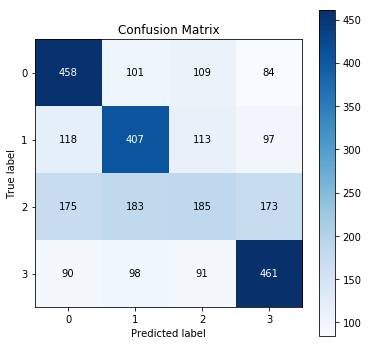

In [21]:
print(confusion_matrix(y_testt, testing_predictions))

skplt.metrics.plot_confusion_matrix(y_testt, testing_predictions, figsize=(6,6))
plt.show()

- In the classification report: It is reassuring that the f1 scores are highest for the highest and lowest scoring comments. 
- Given the nature of the sensitive forum, increasing the detection and classification of potentially harmful comments is desirable, thus increasing false negatives and increasing recall (at the expense of precision).

In [20]:
cv_predict = cross_val_predict(lr, X_traint, y_traint, cv=kf)
print(classification_report(y_traint, cv_predict))

              precision    recall  f1-score   support

           0       0.49      0.53      0.51      2926
           1       0.49      0.50      0.50      2943
           2       0.36      0.30      0.33      2962
           3       0.50      0.53      0.52      2938

    accuracy                           0.47     11769
   macro avg       0.46      0.47      0.46     11769
weighted avg       0.46      0.47      0.46     11769



In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. 

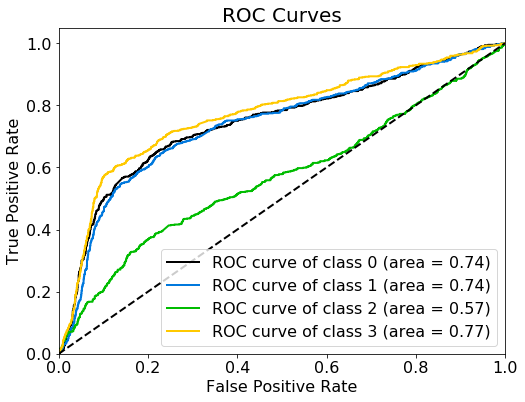

Area under ROC curve (ROC-AUC):
Class 0: 0.74
Class 1: 0.74
Class 2: 0.57
Class 3: 0.77


In [56]:
y_test_bint = label_binarize(y_testt, lr.classes_)

skplt.metrics.plot_roc(y_testt, lr.predict_proba(X_testt), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6))
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(lr.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bint[:, i], lr.predict_proba(X_testt)[:, i]), 2))

## For the sake of analysis, I have binarized my target variable 

In [20]:
def sampling_binary(X,y):   
    y_b = pd.qcut(y, 2, labels = [0,1])
    Xs,ys = RandomUnderSampler(replacement=True).fit_resample(X, y_b)
    print(Xs.shape, ys.shape)
    scaler = StandardScaler()
    Xs = pd.DataFrame(scaler.fit_transform(Xs), columns = X.columns)
    ys = pd.DataFrame(ys, columns=['comment_score'])
    
    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=1, shuffle=True)
    return X_train, X_test, y_train, y_test

In [24]:
X_trainb, X_testb, y_trainb, y_testb = sampling_binary(sw_tf, sw.comment_score)

(14938, 5000) (14938,)


Due to the binary nature of our target metric, the baseline is roughly 0.5

In [25]:
y_testb['comment_score'].value_counts(normalize=True).max()

0.5046854082998661

In [26]:
lr_binary = LogisticRegression(C=0.1, random_state=1).fit(X_trainb, y_trainb)

In [29]:
cv = cross_val_score(lr_binary, X_trainb, y_trainb, cv=kf).mean()

In [30]:
training_predictionsb = lr_binary.predict(X_trainb)
testing_predictionsb = lr_binary.predict(X_testb)

In [32]:
print('Training score', lr_binary.score(X_trainb, y_trainb)) #very overfit 
print('Testing score', lr_binary.score(X_testb, y_testb))
print('CV score', cv)

Training score 0.9137238493723849
Testing score 0.6204819277108434
CV score 0.6049373029821185


It is reassuring that the model is correctly classifying **more** harmful (low scoring comments). 

[[1031  449]
 [ 685  823]]


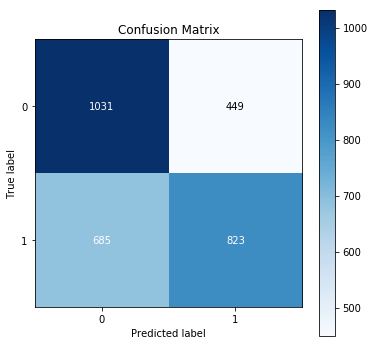

In [38]:
print(confusion_matrix(y_testb, testing_predictionsb))

skplt.metrics.plot_confusion_matrix(y_testb, testing_predictionsb, figsize=(6,6))
plt.show()

In [37]:
cv_predict_b = cross_val_predict(lr_binary, X_trainb, y_trainb, cv=kf)
print(classification_report(y_trainb, cv_predict_b))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      5989
           1       0.62      0.55      0.58      5961

    accuracy                           0.60     11950
   macro avg       0.61      0.60      0.60     11950
weighted avg       0.61      0.60      0.60     11950



Ensure the predicted prob are returned from cross val predict (due to very overfitted training data)

In [137]:
cv_predict_prob = cross_val_predict(lr_binary, X_trainb, y_trainb['comment_score'], cv=kf, method='predict_proba')

In [149]:
Y_pp = pd.DataFrame(cv_predict_prob, 
             columns=['low', 'high'], index = y_trainb.index)
round(Y_pp,5).head()

,low,high
3612,0.85659,0.14341
9032,0.99986,0.00014
11304,0.95737,0.04263
13423,0.33814,0.66186
12847,0.00556,0.99444


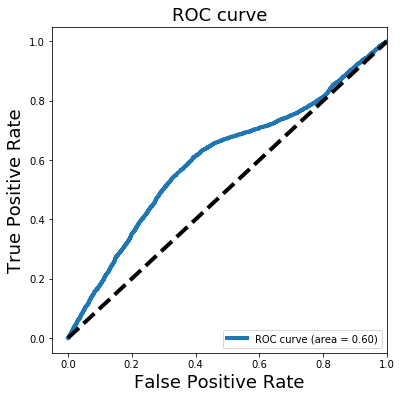

In [151]:
fpr, tpr, threshold = roc_curve(y_trainb['comment_score'], Y_pp.high)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [152]:
def predict_threshold_lowest_class(x, threshold=0.5):
    if x >= threshold:
        return 0
    else:
        return 1

In [155]:
Y_pp['50%_thresh'] = Y_pp.low.apply(predict_threshold_lowest_class, threshold=0.5)
Y_pp['actual'] = y_trainb
round(Y_pp,5).head()

,low,high,50%_thresh,actual
3612,0.85659,0.14341,0,0
9032,0.99986,0.00014,0,1
11304,0.95737,0.04263,0,1
13423,0.33814,0.66186,1,1
12847,0.00556,0.99444,1,1


In [156]:
def scores_at_thresholds(probs):
    predictions = [probs.apply(predict_threshold_lowest_class, threshold=i) 
                   for i in np.linspace(0, 1, 1000)]
    scores = np.array(
    [(threshold, 
      accuracy_score(Y_pp['actual'], predictions[i]),
      precision_score(Y_pp['actual'], predictions[i]),
      recall_score(Y_pp['actual'], predictions[i]), 
      f1_score(Y_pp['actual'], predictions[i])) 
     for i, threshold in enumerate(np.linspace(0, 1, 1000))])
    return scores

In [157]:
scores = scores_at_thresholds(Y_pp.low)

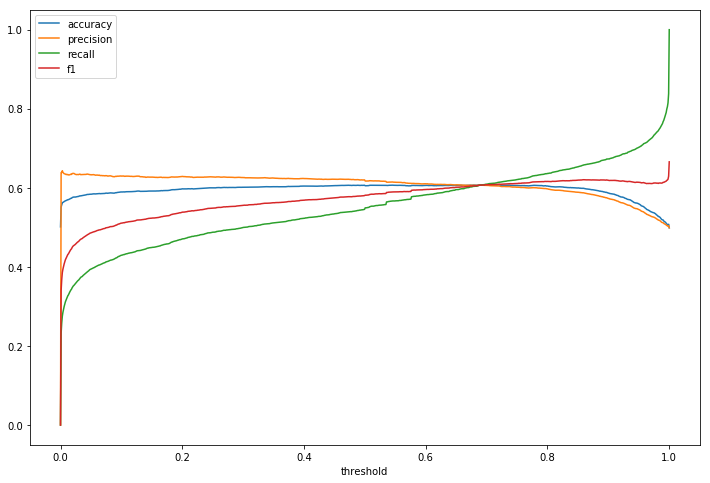

In [158]:
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(scores[:, 0], scores[:, 1], label='accuracy')
plt.plot(scores[:, 0], scores[:, 2], label='precision')
plt.plot(scores[:, 0], scores[:, 3], label='recall')
plt.plot(scores[:, 0], scores[:, 4], label='f1')
plt.legend()
plt.xlabel('threshold')
plt.show();

Classification report at 50 percent threshold (which is the as same above)

In [159]:
print(classification_report(Y_pp['actual'], Y_pp['50%_thresh']))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      5989
           1       0.62      0.55      0.58      5961

    accuracy                           0.60     11950
   macro avg       0.61      0.60      0.60     11950
weighted avg       0.61      0.60      0.60     11950



- Given the nature of this forum, we want to tune the model towards increasing the detection of harmful or damaging comments. Thus increasing detection of low scoring comments is critical. This is done by decreasing the threshold, increasing false negatives. 

In [168]:
Y_pp['45%'] = Y_pp.low.apply(predict_threshold_lowest_class, threshold=0.45)
round(Y_pp,5).head()

,low,high,50%_thresh,actual,45%
3612,0.85659,0.14341,0,0,0
9032,0.99986,0.00014,0,1,0
11304,0.95737,0.04263,0,1,0
13423,0.33814,0.66186,1,1,1
12847,0.00556,0.99444,1,1,1


In [169]:
#classification report at 45 percent threshold
print(classification_report(Y_pp['actual'], Y_pp['45%']))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63      5989
           1       0.62      0.53      0.57      5961

    accuracy                           0.61     11950
   macro avg       0.61      0.61      0.60     11950
weighted avg       0.61      0.61      0.60     11950



Higher recall at class 0, thus increasing detection of lower scoring comments. 

## Analysis of coefficients 

**In a world where silence or insensitivity often makes matters worse, it's time to talk about our language.**


**These terms have been found to decrease comment scores and align with ideas within research in the mental health industry.**

- 'change world', 'changes', 'meaning life': suggests spamming the sub with generic uplifting comments. Research has shown that vague, over-simplistic language is innappropriate. 

- 'bad thing', 'makes sad', 'destructive: Suggest casting blame and and guilt-tripping terms. Research shows judgement can be damaging. 

- 'Passion', 'lots love': It has been shown that highly emotive language is damaging. 

- 'doesn sound': Trivialising the situation, downplaying ones agency and lacking compassion.

- 'hotline', 'proving wrong': Offering solutions or posing too aggressively as a role model 

**These terms have been found to increase comment scores and align with ideas within research in the mental health industry.**


- 'im sorry', 'ive got' 'just felt', 'did try', 'reminds', 'did help' 
- personal, use of 'I', enagaging in conversation and relates to the situation, validating emotions. 

- 'taboo' - addressing the idea of taboo and stigma 

- 'thoughts feelings', 'people struggle' - evokes compassion

- 'service', 'laws' - factual and possibly clinical 

This research is from an online cross-sectional survey in which participants were asked to rate descriptors pertaining to suicidal behaviour according to perceived acceptability. 


**Limitations:**

- Difficult to interpret these what these words represent without context.
- Varies so much for what people find helpful, making it very difficult to predict scores.


Padmanathan P, Biddle L, Hall K, Scowcroft E, Nielsen E, et al. (2019) Language use and suicide: An online cross-sectional survey. PLOS ONE 14(6): e0217473. https://doi.org/10.1371/journal.pone.0217473